In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Multinomial Logistic Regression
This notebook is a part of the Meme Classification Project the end semester exam for Machine Learning (CSE425)

## Import Modules

In [ ]:
import cv2
from matplotlib import pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
from PIL import Image
from pickle import dump, load
import seaborn as sns
from skimage import feature
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, f1_score, confusion_matrix
from tqdm.contrib.concurrent import thread_map
from time import strftime, time, localtime, perf_counter

## Load Dataset
Load the dataset from the parquet file. The paths provided in the dataset also need to be changed to local paths. Hence, replace the paths to point to the images.

In [ ]:
df = pd.read_parquet('../../data/imgflip/meme_entries/meme_entries.parquet')
df.path = df.path.str.replace('D:/Memes2024', '../../datasets/ImgFlipMemes')
df

## EDA
Few of the exploratory data analyses performed are as follows.

In [ ]:
path = df.path.iloc[69]

### Colour Histogram
Select an arbitrary image to view its colour histogram. Colour histogram can help analyse colour distribution, and style of memes.

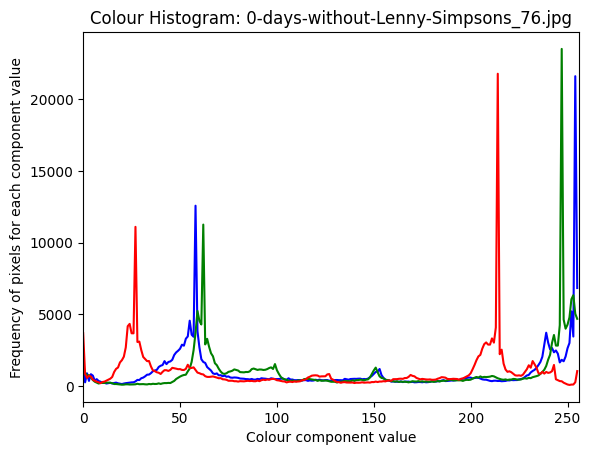

In [ ]:
img = cv2.imread(path)
for i, col in enumerate(('b', 'g', 'r')):
    hist = cv2.calcHist([img], [i], None, [256], (0, 256))
    plt.plot(hist, color=col)
    plt.xlim([0, 256])
plt.title(f'Colour Histogram: {path.split("/")[-1]}')
plt.xlabel('Colour component value')
plt.ylabel('Frequency of pixels for each component value')
plt.show()

### HSV Histogram
HSV histogram shows the distribution of hue, saturation, and value (brightness). This helps understand the tone, and colour intensity amongst other things.

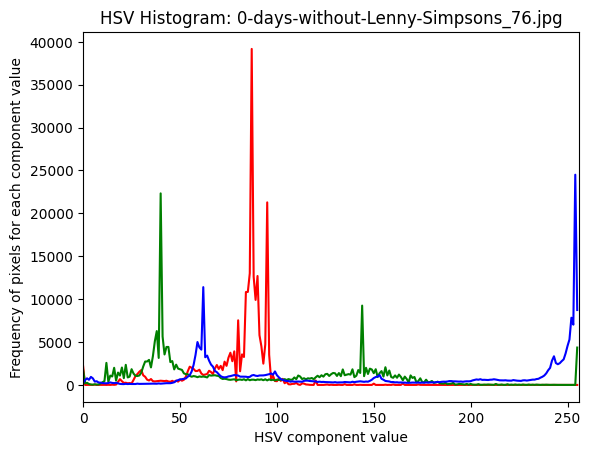

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
for i, col in enumerate(('r', 'g', 'b')):
    hist = cv2.calcHist([img], [i], None, [256], (0, 256))
    plt.plot(hist, color=col)
    plt.xlim([0, 256])
plt.title(f'HSV Histogram: {path.split("/")[-1]}')
plt.xlabel('HSV component value')
plt.ylabel('Frequency of pixels for each component value')
plt.show()

### Greyscale Histogram
Helps visualise almost the same information as the above, except, without the colour distractions.

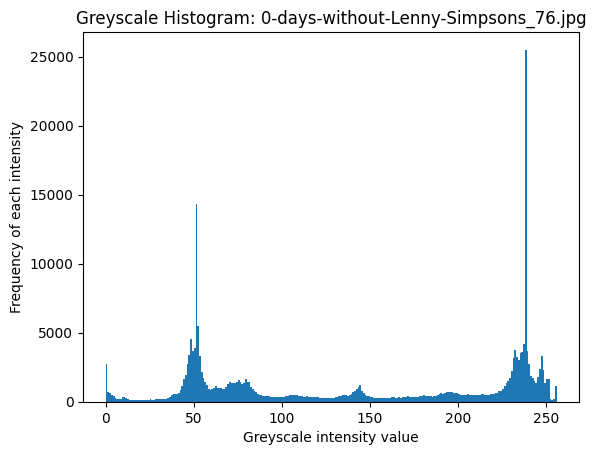

In [ ]:
img = cv2.imread(path, 0)
plt.hist(img.ravel(), 256, [0, 256])
plt.title(f'Greyscale Histogram: {path.split("/")[-1]}')
plt.xlabel('Greyscale intensity value')
plt.ylabel('Frequency of each intensity')
plt.show()

### Extracting Texture Features

This section is for extracting LBP (Local Binary Pattern). LBP is used to capture texture patterns, making it valuable for image analysis, especially in meme analysis projects.

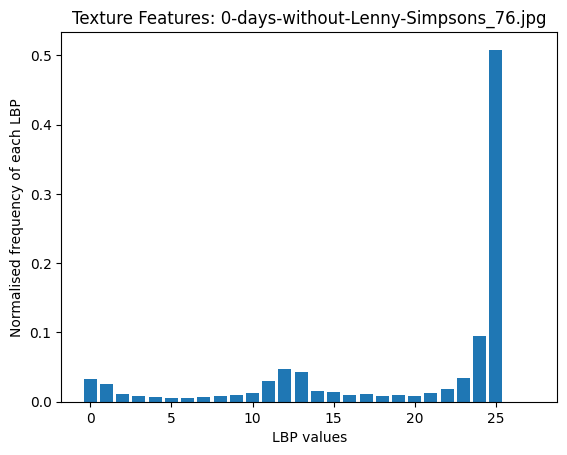

In [ ]:
# Convert image, if coloured, to greyscale
if len(img.shape) == 3:
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
else:
    img_grey = img

# Compute LBP features
lbp = feature.local_binary_pattern(img_grey, P=24, R=8, method="uniform")

# Calculate the histogram
n = lbp.max() + 1
hist, _ = np.histogram(lbp, bins=np.arange(0, n + 3), range=(0, n + 2))

# Normalising the histogram
hist = hist.astype("float")
hist /= (hist.sum() + 1e-7)

# Display the features
plt.bar(x=np.arange(0, n + 2), height=hist)
plt.xlabel('LBP values')
plt.ylabel('Normalised frequency of each LBP')
plt.title(f'Texture Features: {path.split("/")[-1]}')
plt.show()

### Pipeline
Combine all the feature extractions into a pipeline

In [ ]:
def extract_features(image_path):
    global dropped_paths
    if not os.path.exists(image_path):
        print(f'Dropped {image_path}, since it doesn\'t exist')
        dropped_paths.append(image_path)
        return None

    # Check if the file is a GIF
    if image_path.endswith('.gif') or image_path.endswith('.GIF'):
        img = Image.open(image_path)
        img = img.convert('RGB') # Convert to RGB
        img = np.array(img) # Convert to NumPy array
    else:
        img = cv2.imread(image_path)
        if img is None or img.size == 0:
            print(f'Failed to load image at path {image_path}')
            dropped_paths.append(image_path)
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to standard RGB

    # convert image to HSV and calculate HSV histogram
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv_features = []
    for i in range(3):  # for each channel
        hist = cv2.calcHist([hsv_img], [i], None, [256], [0, 256])
        hsv_features.extend(hist.flatten())

    # convert image to greyscale and calculate greyscale histogram
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    greyscale_hist = cv2.calcHist([grey], [0], None, [256], [0, 256])
    greyscale_features = greyscale_hist.flatten()

    # calculate LBP features
    lbp = feature.local_binary_pattern(grey, P=24, R=8, method="uniform")
    n = int(lbp.max() + 1)
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n + 3), range=(0, n + 2))
    lbp_features = lbp_hist.astype("float")
    lbp_features /= (lbp_features.sum() + 1e-7)  # normalise histogram

    # Check the length of the LBP features and append a zero if necessary, to have a consistent length of features in all images
    if len(lbp_features) == 27:
        lbp_features = np.append(lbp_features, 0)

    # concatenate all features into a single feature vector
    feature_vector = np.hstack([hsv_features, greyscale_features, lbp_features])

    return feature_vector

# Preprocessing
The following section focuses on preprocessing the dataset

## Extract features from the dataset

In [ ]:
# Get number of cores
num_cores = multiprocessing.cpu_count() - 1
dropped_paths = []

# Use joblib to parallelise feature extraction
start = time.time()
features = thread_map(extract_features, paths, max_workers=num_cores)
end = time.time()
print(f"Time taken to extract features from {len(paths)} images: {end-start:.2f} seconds")

  0%|          | 0/124201 [00:00<?, ?it/s]

In [ ]:
# Filtering data and converting to np array
feats = np.array([_ for _ in features if _ is not None])

# Save the features
with open('features.bin', 'wb') as f:
    dump(feats, f)

In [ ]:
with open('dropped_paths.bin', 'wb') as f:
    dump(dropped_paths, f)

In [ ]:
with open('/content/drive/MyDrive/Meme-Research/dropped_paths.bin', 'rb') as f:
    dropped_paths = load(f)

In [ ]:
# Load features from the save files
with open('/content/drive/MyDrive/Meme-Research/features.bin', 'rb') as f:
    feats = load(f)

### Get Dependant and Independant Variables

In [ ]:
for i in dropped_paths:
    print(f'Dropped {i}')
    df.drop(df[df['path'] == i].index, inplace=True)

In [ ]:
df.to_parquet('filtered_dataset.parquet')

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Meme-Research/filtered_dataset.parquet')
df.shape

(115343, 5)

In [ ]:
X = feats
X = X.astype('float32')

In [ ]:
df['template_id'] = LabelEncoder().fit_transform(df['template_name'])
y = df['template_id'].copy()
df

,id,template_name,path,phash,template_id
0,0-days-without-lenny-simpsons,0-days-without-lenny-simpsons,../../dataset/ImgFlipMemes/0-days-without-Lenn...,0fe9b236e884fc38,0
1,0-days-without-Lenny-Simpsons_23,0-days-without-lenny-simpsons,../../dataset/ImgFlipMemes/0-days-without-Lenn...,07e5ba2ee806fe30,0
2,0-days-without-Lenny-Simpsons_1,0-days-without-lenny-simpsons,../../dataset/ImgFlipMemes/0-days-without-Lenn...,1fed3226e804fe38,0
3,0-days-without-Lenny-Simpsons_24,0-days-without-lenny-simpsons,../../dataset/ImgFlipMemes/0-days-without-Lenn...,07e1b83ee886fa38,0
4,0-days-without-Lenny-Simpsons_10,0-days-without-lenny-simpsons,../../dataset/ImgFlipMemes/0-days-without-Lenn...,17e5b22ee806fe30,0
...,...,...,...,...,...
124195,problems-stress-pain_27,problems-stress-pain,../../dataset/ImgFlipMemes/problems-stress-pai...,b3588146bece4e39,755
124196,skeleton-computer-84,skeleton-computer,../../dataset/ImgFlipMemes/Skeleton-Computer/s...,e1e68b1929253d3d,853
124197,nick-young-178,nick-young,../../dataset/ImgFlipMemes/Nick-Young/nick-you...,4bd5913e14da4e55,660
124198,success-kid-original-196,success-kid-original,../../dataset/ImgFlipMemes/Success-Kid-Origina...,1d1d301f32c3f2e3,939


In [ ]:
feats.shape

(115343, 1052)

## Training a Classifier
Using the features extracted to train a multinomial logistic regression classifier

### Split dataset into training and testing

In [ ]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

mcc_scores = []
kappa_scores = []
f1_scores = []

split = list(skf.split(X, y))
with open('/content/drive/MyDrive/Meme-Research/split.bin', 'wb') as f:
    dump(split, f)

# Lambda to get current time (Google Colab is weird)
get_time = lambda _: strftime(_, localtime(time()+19800))

i = 0
f = open('/content/drive/MyDrive/Meme-Research/mlr_exp_log.txt', 'w')
for train_index, test_index in split:
    X_train, X_test = X[train_index], X[test_index]
    y = y.reset_index(drop=True)
    y_train, y_test = y[train_index], y[test_index]

    clf = LogisticRegression(class_weight='balanced', solver='lbfgs', random_state=42, n_jobs=-1)

    f.write(f'Iteration: {i} ({get_time("%H%M%S")})\n')
    print(f'Fitting {i} [Started at {get_time("%I:%M:%S%p")}]')
    s = perf_counter()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mcc = matthews_corrcoef(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    f1 =  f1_score(y_test, y_pred, average='weighted')
    print(f'{mcc = }, {kappa = }, {f1 = } [time spent: {perf_counter() - s}s]')
    mcc_scores.append(mcc)
    kappa_scores.append(kappa)
    f1_scores.append(f1)
    f.write(f"  Mathew's Correlation Coefficient: {mcc}\n")
    f.write(f"  Cohen Kappa Score: {kappa}\n")
    f.write(f"  F1 Score: {f1}\n\n")
    with open(f'/content/drive/MyDrive/Meme-Research/mlr_model_{i}.bin', 'wb') as g:
       dump(clf, g)
    i += 1

f.close()

with open('/content/drive/MyDrive/Meme-Research/mlr_results.txt', 'w') as f:
    f.write(f"Mathew's Correlation Coefficient: {np.mean(mcc_scores):.4f} ± {np.std(mcc_scores):.4f}\n")
    f.write(f"Cohen Kappa Score: {np.mean(kappa_scores):.4f} ± {np.std(kappa_scores):.4f}\n")
    f.write(f"F1 Score: {np.mean(f1_scores): .4f} ± {np.std(f1_scores):.4f}\n")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fitting 0 [Started at 06:43:51PM]
mcc = 0.9143176123838599, kappa = 0.9142908680843176, f1 = 0.911758541284547 [time spent: 2328.617738116s]
Fitting 1 [Started at 07:22:40PM]
mcc = 0.9195654910171939, kappa = 0.9195420634086615, f1 = 0.9167092556112412 [time spent: 2389.976257400999s]
Fitting 2 [Started at 08:02:30PM]


# Results

In [ ]:
with open('/content/drive/MyDrive/Meme-Research/mlr_results.txt') as f:
  r = f.read()

print('Mean Scores:')
print(r)

Mean Scores:
Mathew's Correlation Coefficient: 0.9155858082165867
Cohen Kappa Score: 0.9155566465419909
F1 Score: 0.9134127613178891



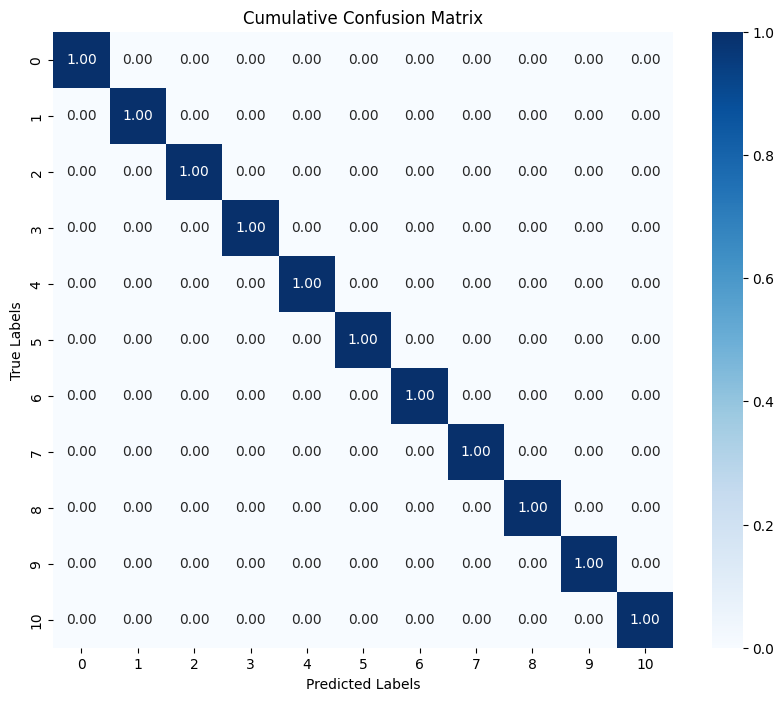

In [21]:
limit = .01

# Load the split data
split = load(open('/content/drive/MyDrive/Meme-Research/split.bin', 'rb'))

# Initialize lists to collect all true and predicted labels
all_y_test = []
all_y_pred = []

# Iterate through the splits to collect predictions
for i in range(2): # Assuming we only want to evaluate the first 2 models based on your code
    test_index = split[i][1][:int(limit*len(split[i][1]))]
    y = y.reset_index(drop=True) # Resetting the index is crucial
    X_test, y_test = X[test_index], y[test_index]

    # X_test, y_test = X_test[:int(limit*len(X_test))], y_test[:int(limit*len(y_test))]

    # Load the trained model
    with open(f'/content/drive/MyDrive/Meme-Research/mlr_model_{i}.bin', 'rb') as g:
        clf = load(g)

    # Make predictions
    y_pred = clf.predict(X_test)

    # Collect true and predicted labels
    all_y_test.extend(y_test.tolist())
    all_y_pred.extend(y_pred.tolist())

# Get all unique labels from BOTH true and predicted to ensure consistency
labels = np.unique(all_y_test + all_y_pred)
labels = labels[:len(labels)//2]

# Create the confusion matrix with explicit labels
cm = confusion_matrix(all_y_test, all_y_pred, labels=labels)

# Normalize the confusion matrix by row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Convert to DataFrame for easier plotting, using the consistent labels
cm_df = pd.DataFrame(cm_normalized, index=labels, columns=labels)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='.2f', cmap='Blues')
plt.title('Cumulative Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()